In [1]:
! nvidia-smi

Wed Nov  9 12:38:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.43.04    Driver Version: 515.43.04    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:03:00.0 Off |                  N/A |
| 30%   40C    P0   108W / 350W |      0MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
| 30%   

In [1]:
import os, random, string 

cuda_device = 3
os.environ["CUDA_VISIBLE_DEVICES"]= str(cuda_device)

In [2]:
# "Basic" py library
import pandas as pd
import numpy as np
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Stats 
from mlxtend.evaluate import permutation_test

# visualisation
from matplotlib import pyplot as plt # basic visualisation in py
import seaborn as sns # great to interact with dataframes
import plotly.express as px # powerfull for interactive figures
from tqdm import tqdm  # generats progress bar to controll steps

# ML 
import torch # Pytorch, Meta's library for ML
import torch.nn as nn # torch module for neural networks 

import transformers # HuggingFace library to use pretrained models
from transformers import BertTokenizer, BertModel
from transformers import pipeline
import datasets

In [4]:
def set_seed(seed: int):
    """Helper function for reproducible behavior to set the seed in ``random``, 
        ``numpy``, ``torch`` and/or ``tf`` (if installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
    
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
    if is_tf_available():
        import tensorflow as tf

        tf.random.set_seed(seed)
        
        
def get_PN_em(x, neg_em_list):
    if x in neg_em_list:
        return "Negative"
    elif x == "HA":
        return "Positive"
    else:
        return "Missing"

    
Coding_emotions = {
    "AN": "Anger",
    "AP": "Apprehension",
    "SD": "Sadness",
    "CO": "Confusion",
    "HA": "Happiness",
    
    "Missing": "Missing",
}


def Coding_em_binary_P(emotion_str):
    if emotion_str == "AP": 
        return "Positive"
    elif emotion_str == "Missing":
        return "Missing"
    else:
        return "Negative"
    
    
def get_DrmRpr_SA_scores_Collection(dream_records, N_emotions):
    DRlbl_SAlbl = []
    for collection in tqdm(set(dream_records["collection"])):

        if N_emotions == "one":
            lcl_df          = dream_records[
                                    dream_records["collection"].isin([collection]) & 
                                    dream_records["# Emotions"].isin([1])       
                            ]

        elif N_emotions == "all":
            lcl_df          = dream_records[
                                    dream_records["collection"].isin([collection]) & 
                                    ~dream_records["# Emotions"].isin([0])       
                            ]
            
        elif N_emotions == ">1":
            lcl_df          = dream_records[
                                    dream_records["collection"].isin([collection]) & 
                                    ~dream_records["# Emotions"].isin([0,1])        
                            ]
        else:
            print("No such setting {}".formt(N_emotions))
            break

            
        lcl_DRlbl_SAlbl = {} # Dream-Report label vs Sent. Analysis label
        for emotions_seq, SA_lbl in lcl_df[["Emotions","2W_SA_label"]].values:

            SA_lbl_to_int = 1 if SA_lbl == "POSITIVE" else 0

            for emt in emotions_seq.split("_"):

                local_lst = lcl_DRlbl_SAlbl.get(Coding_emotions[emt], [])
                local_lst.append(SA_lbl_to_int)
                lcl_DRlbl_SAlbl[Coding_emotions[emt]] = local_lst

        lcl_DRlbl_SAlbl = [
            [k,(sum(v)/len(v)), collection] for k,v in lcl_DRlbl_SAlbl.items()
        ]
        
        for trpl in lcl_DRlbl_SAlbl:
            DRlbl_SAlbl.append(trpl)
       
    return DRlbl_SAlbl


def cutted_barplot(data, X, Y, palette, top, bottom, x_lbl, y_lbl):
    """Visualisation function, draws a "cutted" barplot for those cases where one 
        or more outliers make the visualisation complicated

    Args:
        data: df, the data to visulise 
        X, Y: string, the the name of x and y axis 
        palette: color set
        top, bottom: integer, where to interrupt and reptart the plot (on y axe)
        x_lbl, y_lbl: string, names of the labels for the axes
    """
    f, (ax_top, ax_bottom) = plt.subplots(
        ncols=1, 
        nrows=2, 
        sharex=True, 
        gridspec_kw={'hspace':0.05},
        figsize=(20,8),
    )

    g1 = sns.barplot(
        data=data,
        x=X,
        y=Y,
        palette=palette,
        ax=ax_top
    )
    g1.set_xlabel(""), g1.set_ylabel("")

    g2 = sns.barplot(
        data=data,
        x=X,
        y=Y,
        palette=palette,
        ax=ax_bottom
    )
    g2.set_xlabel(""), g2.set_ylabel("")

    ax_top.set_ylim(bottom=top)   # those limits are fake
    ax_bottom.set_ylim(0,bottom)

    sns.despine(ax=ax_bottom)
    sns.despine(ax=ax_top, bottom=True)

    ax = ax_top
    d = .005  # how big to make the diagonal lines in axes coordinates
    # arguments to pass to plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal

    ax2 = ax_bottom
    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal

    plt.xticks(
        rotation=45, 
        horizontalalignment='right',
    )

    f.text(0.5, -.1, x_lbl, ha='center')
    f.text(.07, 0.5, y_lbl, va='center', rotation='vertical')
    plt.show()

In [5]:
# Set visual style
sns.set("talk")
sns.set_style("whitegrid")

#  set the rabdom seed
seed = 31
set_seed(seed)

# Get punctuation and English stop-words
punct         = string.punctuation 
en_stop_words = stopwords.words('english')

# Table of Content

click on the titles to reach the described sections

---------
[Loading Data](#intro)

[SA - Data Collection](#ssa)

[2-Way results](#2wresults)

[2-Way Error Analysis](#2werran)

## Loading data<a id='intro'></a>

In [6]:
# Load the dataset in CSV (already has BERT–Large emb. and PCA/t-SNE coordinates)
dream_records = pd.read_csv(
    "Reports_DreamerEmotions_PCAxy_tSNExy_KMCluster2_KMCluster6.csv"
)

with open('BERT-Large-Cased_dream_records.npy', 'rb') as f:
    T_encoding = np.load(f)

## Sentiment Analysis - Data Collection<a id='ssa'></a>

2-Way Sentiment Analysis 

In [8]:
sent_pipeline = pipeline(
    "sentiment-analysis", 
    truncation=True, 
    max_length=512, 
    device=0,
)

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [6]:
"""
SST-2 Output

{'label': 'POSITIVE', 'score': 0.9998},
"""
print()

In [10]:
raw_data = dream_records["report"].tolist()

In [11]:
predictions = [
    list(sent_pipeline(report)[0].values())
    for report in tqdm(raw_data)
]    

  0%|                                          | 1/1845 [00:00<17:30,  1.76it/s]/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████| 1845/1845 [00:07<00:00, 253.46it/s]


In [12]:
dream_records["2W_SA_label"], dream_records["2W_SA_score"] = zip(*predictions)

6-Way Sentiment Analysis 

In [13]:
sent_pipeline = pipeline(
    "text-classification",
    model='bhadresh-savani/distilbert-base-uncased-emotion', 
    return_all_scores=True, 
    truncation=True, 
    max_length=512,
    device=0,
)

/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/pipelines/text_classification.py:89: UserWarning: `return_all_scores` is now deprecated, use `top_k=1` if you want similar functionnality
  warnings.warn(


In [14]:
"""
Emotion Output:
[[
{'label': 'sadness', 'score': 0.0006792712374590337}, 
{'label': 'joy', 'score': 0.9959300756454468}, 
{'label': 'love', 'score': 0.0009452480007894337}, 
{'label': 'anger', 'score': 0.0018055217806249857}, 
{'label': 'fear', 'score': 0.00041110432357527316}, 
{'label': 'surprise', 'score': 0.0002288572577526793}
]]
"""
print()

In [15]:
predictions = [
    sent_pipeline(report)
    for report in tqdm(raw_data)
]    

dream_records["6W_SA_dict"] = predictions

  0%|                                                  | 0/1845 [00:00<?, ?it/s]/srv/galene1/lb540/miniconda/envs/main_39/lib/python3.9/site-packages/transformers/pipelines/base.py:1036: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████████████████████████████████| 1845/1845 [00:06<00:00, 274.16it/s]


In [16]:
# # Store to .csv
# dream_records.to_csv(
#     "Reports_DreamerEmotions_PCACho_tsneCho_KMCluster2_KMCluster6_2WSA_6WSA.csv", 
#     index=False,
# )

## 2-Way SA Results<a id='2wresults'></a>

In [6]:
# Load the dataset in CSV (if already has BERT–Large emb. and PCA/t-SNE coordinates)
dream_records = pd.read_csv(
    "Reports_DreamerEmotions_PCACho_tsneCho_KMCluster2_KMCluster6_2WSA_6WSA.csv"
)

In [7]:
x_order = ["Anger", "Apprehension", "Confusion", "Sadness", "Missing", "Happiness"]
N_emotions = "one" # or "all"

DRlbl_SAlbl_all    = get_DrmRpr_SA_scores_Collection(dream_records, N_emotions="all")
DRlbl_SAlbl_all_df = pd.DataFrame(
    DRlbl_SAlbl_all, columns=[
    "Emotion", "p(l=POSITIVE)", "collection"]
)

DRlbl_SAlbl_one    = get_DrmRpr_SA_scores_Collection(dream_records, N_emotions="one")
DRlbl_SAlbl_one_df = pd.DataFrame(
    DRlbl_SAlbl_one, columns=[
    "Emotion", "p(l=POSITIVE)", "collection"]
)

DRlbl_SAlbl_mne    = get_DrmRpr_SA_scores_Collection(dream_records, N_emotions=">1")
DRlbl_SAlbl_mne_df = pd.DataFrame(
    DRlbl_SAlbl_mne, columns=[
    "Emotion", "p(l=POSITIVE)", "collection"]
)

100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 1206.24it/s]


In [8]:
DRlbl_SAlbl_one_df["# Emotions"] = ["1"]*len(DRlbl_SAlbl_one_df)
DRlbl_SAlbl_mne_df["# Emotions"] = [">1"]*len(DRlbl_SAlbl_mne_df)
DRlbl_SAlbl_all_df["# Emotions"] = ["all"]*len(DRlbl_SAlbl_all_df)

DRlbl_SAlbl_full_df = pd.concat([DRlbl_SAlbl_all_df, DRlbl_SAlbl_one_df, DRlbl_SAlbl_mne_df])
DRlbl_SAlbl_full_df = DRlbl_SAlbl_full_df.reset_index(drop=True)

In [9]:
x_order = ["Anger", "Apprehension", "Confusion", "Sadness","Happiness"]
col_order = ["1", ">1", "all"]

Text(0.5, 0.53, 'Random')

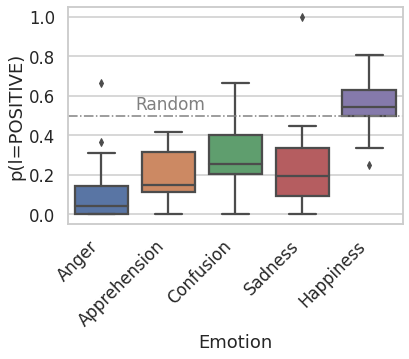

In [23]:
g = sns.boxplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="p(l=POSITIVE)",
    order=x_order,
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

g.axhline(.50, ls='-.', color="gray", linewidth=1.5)
g.text(.5, .53, "Random", color="gray", fontsize=17) 

In [ ]:
g = sns.catplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="p(l=POSITIVE)",
    order=x_order,
    col="# Emotions",
    kind="box",
    col_order=col_order,
    errorbar=("se", 1)
)

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
)

for cnt, axes in enumerate(g.axes.flat):
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.axhline(.50, ls='-.', color="gray", linewidth=1.5)
    if cnt == 0:
        axes.text(1, .53, "Random", color="gray", fontsize=17) 
# g.savefig("SA_dream_reports_all.png", dpi=800)

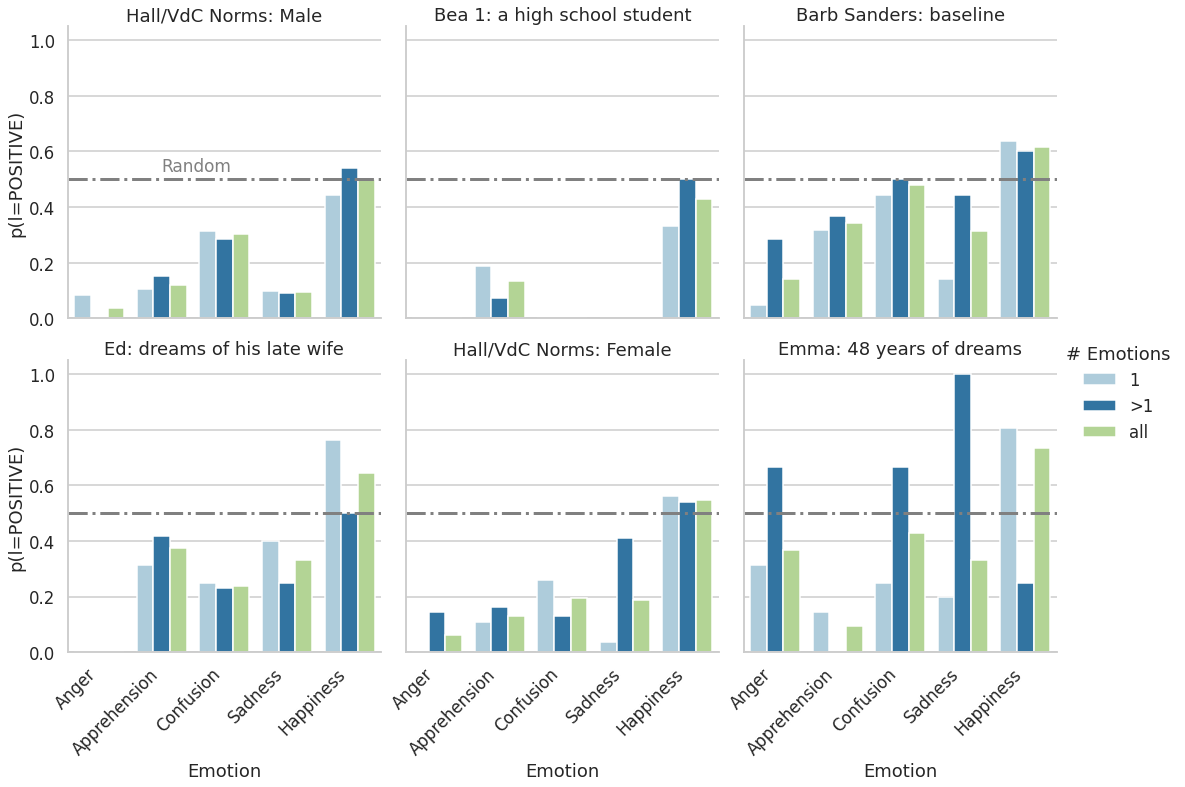

In [27]:
g = sns.catplot(
    data=DRlbl_SAlbl_full_df, 
    x="Emotion",
    y="p(l=POSITIVE)",
    hue="# Emotions",
    order=x_order,
    col="collection",
    kind="bar",
    col_wrap=3,
    hue_order=col_order,
    palette="Paired",
)

for cnt, axes in enumerate(g.axes.flat):
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
    axes.axhline(.50, ls='-.', color="gray", linewidth=3)
    if cnt == 0:
        axes.text(1, .53, "Random", color="gray", fontsize=17) 
    
g.set_titles(template='{col_name}')

## 2-Way Error Analsysis <a id='2werran'></a>

Searching for words that appear fre frequenlty in those reports "correctly" classified as Positive / Negative

In [17]:
sngl_em_ha_P_reports = dream_records[
    dream_records["# Emotions"].isin([1])  &
#     dream_records["Emotions"].isin(["HA"]) &
    dream_records["2W_SA_label"].isin(["POSITIVE"])
]["report"].tolist()

pstv_wrd_frq = {}
for report in sngl_em_ha_P_reports:
    for word in word_tokenize(report):
        if word.lower() in en_stop_words or word.lower() in punct:
            continue
        pstv_wrd_frq[word.lower()] = pstv_wrd_frq.get(word.lower(), 0) + 1

In [18]:
sngl_em_nn_N_reports = dream_records[
    dream_records["# Emotions"].isin([1])  &
#     ~dream_records["Emotions"].isin(["HA"]) &
    dream_records["2W_SA_label"].isin(["NEGATIVE"])
]["report"].tolist()

ngt_wrd_frq = {}
for report in sngl_em_nn_N_reports:
    for word in word_tokenize(report):
        if word.lower() in en_stop_words or word.lower() in punct:
            continue
        ngt_wrd_frq[word.lower()] = ngt_wrd_frq.get(word.lower(), 0) + 1

In [19]:
# Balance frequwncy so to wxpclude commmon words
pstv_wrd_frq_bl = {w:max(f-ngt_wrd_frq.get(w, 0), 0) for w,f in pstv_wrd_frq.items()}
ngt_wrd_frq_bl  = {w:max(f-pstv_wrd_frq.get(w, 0), 0) for w,f in ngt_wrd_frq.items()}

In [20]:
pstv_wrd_frq_df = pd.DataFrame(
                                list(pstv_wrd_frq_bl.items()), 
                                columns=["Word", "Frequency"]
)

ngt_wrd_frq_df = pd.DataFrame(
                                list(ngt_wrd_frq_bl.items()), 
                                columns=["Word", "Frequency"]
)

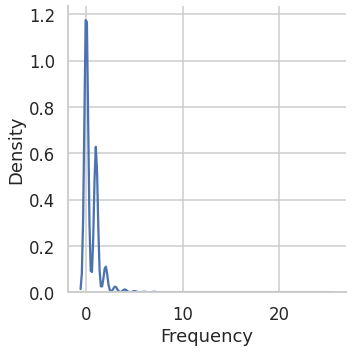

In [21]:
sns.displot(pstv_wrd_frq_df, x="Frequency", kind="kde")

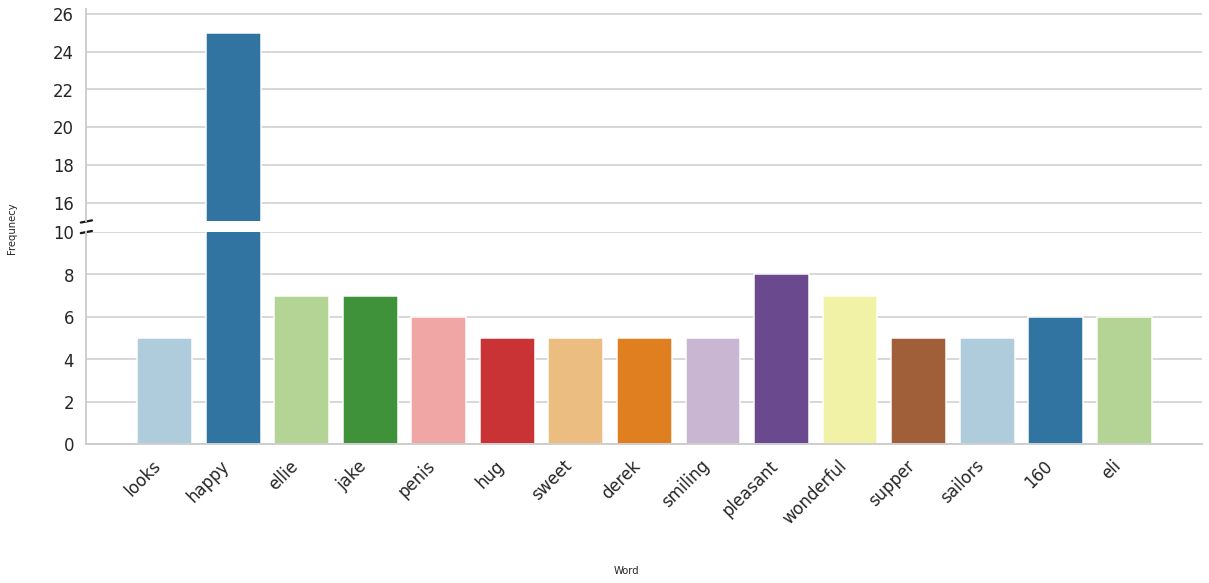

In [22]:
cutted_barplot(
pstv_wrd_frq_df[pstv_wrd_frq_df["Frequency"] >= 5], 
"Word", 
"Frequency", 
"Paired", 
15, 
10, 
"Word", 
"Frequnecy"
)

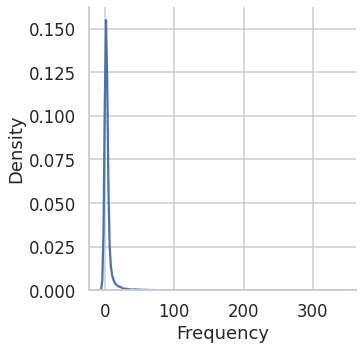

In [23]:
sns.displot(ngt_wrd_frq_df, x="Frequency", kind="kde")

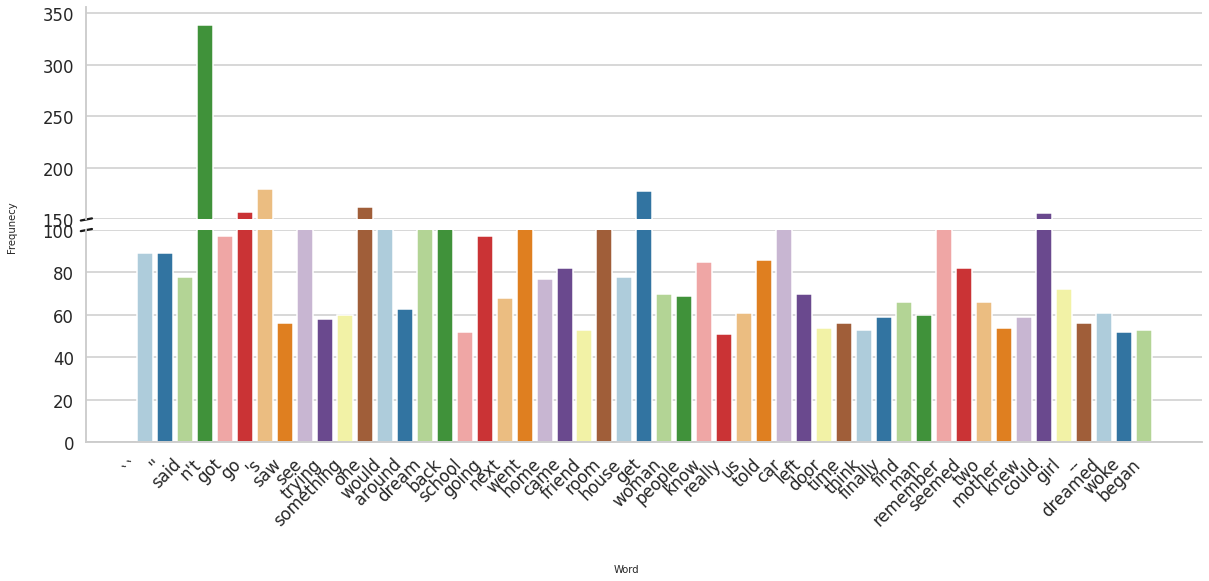

In [24]:
cutted_barplot(
ngt_wrd_frq_df[ngt_wrd_frq_df["Frequency"] > 50],
"Word", 
"Frequency", 
"Paired", 
150,
100, 
"Word", 
"Frequnecy",
)